In [1]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms

In [2]:
import torch
from torchvision import datasets, transforms as T
import torchvision
import time
import copy
import os

In [47]:
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)

In [48]:
shufflenet.fc = torch.nn.Sequential(torch.nn.Linear(in_features=1024,
                                               out_features=2))


In [49]:
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64

data_dir = './NewMasksDatasetFull/Face Mask Dataset'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'faces': transforms.Compose([
#         transforms.RandomResizedCrop(64),
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}
def get_dataset(data_dir, data_transforms ):
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes
train_dataloader, test_dataloader , classes, dataset_sizes=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes)

Classes:  ['WithMask', 'WithoutMask']


In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(shufflenet.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

#num_ftrs = squeezenet.fc.in_features
#squeezenet.fc = nn.Linear(num_ftrs, 128)
net = shufflenet
net = net.cuda()

In [51]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'shufflenet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/5], Step [0/3305], Loss: 0.7157
Epoch [1/5], Step [20/3305], Loss: 0.6995
Epoch [1/5], Step [40/3305], Loss: 0.6831
Epoch [1/5], Step [60/3305], Loss: 0.6893
Epoch [1/5], Step [80/3305], Loss: 0.6974
Epoch [1/5], Step [100/3305], Loss: 0.6991
Epoch [1/5], Step [120/3305], Loss: 0.6975
Epoch [1/5], Step [140/3305], Loss: 0.6916
Epoch [1/5], Step [160/3305], Loss: 0.6914
Epoch [1/5], Step [180/3305], Loss: 0.7012
Epoch [1/5], Step [200/3305], Loss: 0.6836
Epoch [1/5], Step [220/3305], Loss: 0.6989
Epoch [1/5], Step [240/3305], Loss: 0.6853
Epoch [1/5], Step [260/3305], Loss: 0.6833
Epoch [1/5], Step [280/3305], Loss: 0.6853
Epoch [1/5], Step [300/3305], Loss: 0.6879
Epoch [1/5], Step [320/3305], Loss: 0.6837
Epoch [1/5], Step [340/3305], Loss: 0.6853
Epoch [1/5], Step [360/3305], Loss: 0.7101
Epoch [1/5], Step [380/3305], Loss: 0.6889
Epoch [1/5], Step [400/3305], Loss: 0.6942
Epoch [1/5], Step [420/3305], Loss: 0.6770
Epoch [1/5], Step [440/3305], Loss: 0.6710
Epoch [1

Epoch [2/5], Step [380/3305], Loss: 0.7022
Epoch [2/5], Step [400/3305], Loss: 0.5765
Epoch [2/5], Step [420/3305], Loss: 0.6789
Epoch [2/5], Step [440/3305], Loss: 0.5848
Epoch [2/5], Step [460/3305], Loss: 0.5648
Epoch [2/5], Step [480/3305], Loss: 0.5931
Epoch [2/5], Step [500/3305], Loss: 0.6772
Epoch [2/5], Step [520/3305], Loss: 0.6558
Epoch [2/5], Step [540/3305], Loss: 0.6743
Epoch [2/5], Step [560/3305], Loss: 0.5789
Epoch [2/5], Step [580/3305], Loss: 0.7960
Epoch [2/5], Step [600/3305], Loss: 0.6931
Epoch [2/5], Step [620/3305], Loss: 0.5786
Epoch [2/5], Step [640/3305], Loss: 0.6096
Epoch [2/5], Step [660/3305], Loss: 0.6875
Epoch [2/5], Step [680/3305], Loss: 0.6814
Epoch [2/5], Step [700/3305], Loss: 0.6791
Epoch [2/5], Step [720/3305], Loss: 0.8061
Epoch [2/5], Step [740/3305], Loss: 0.4821
Epoch [2/5], Step [760/3305], Loss: 0.5782
Epoch [2/5], Step [780/3305], Loss: 0.5857
Epoch [2/5], Step [800/3305], Loss: 0.5660
Epoch [2/5], Step [820/3305], Loss: 0.6732
Epoch [2/5]

Epoch [3/5], Step [760/3305], Loss: 0.5141
Epoch [3/5], Step [780/3305], Loss: 0.8157
Epoch [3/5], Step [800/3305], Loss: 0.4479
Epoch [3/5], Step [820/3305], Loss: 0.5133
Epoch [3/5], Step [840/3305], Loss: 0.6167
Epoch [3/5], Step [860/3305], Loss: 0.7546
Epoch [3/5], Step [880/3305], Loss: 1.0651
Epoch [3/5], Step [900/3305], Loss: 0.6087
Epoch [3/5], Step [920/3305], Loss: 0.4856
Epoch [3/5], Step [940/3305], Loss: 0.5008
Epoch [3/5], Step [960/3305], Loss: 0.5589
Epoch [3/5], Step [980/3305], Loss: 0.4908
Epoch [3/5], Step [1000/3305], Loss: 0.6136
Epoch [3/5], Step [1020/3305], Loss: 0.6943
Epoch [3/5], Step [1040/3305], Loss: 0.7716
Epoch [3/5], Step [1060/3305], Loss: 0.8287
Epoch [3/5], Step [1080/3305], Loss: 0.5052
Epoch [3/5], Step [1100/3305], Loss: 0.4966
Epoch [3/5], Step [1120/3305], Loss: 0.5836
Epoch [3/5], Step [1140/3305], Loss: 0.6282
Epoch [3/5], Step [1160/3305], Loss: 0.4904
Epoch [3/5], Step [1180/3305], Loss: 0.4977
Epoch [3/5], Step [1200/3305], Loss: 0.4367


Epoch [4/5], Step [1140/3305], Loss: 0.4514
Epoch [4/5], Step [1160/3305], Loss: 0.4856
Epoch [4/5], Step [1180/3305], Loss: 0.4393
Epoch [4/5], Step [1200/3305], Loss: 0.4522
Epoch [4/5], Step [1220/3305], Loss: 0.4570
Epoch [4/5], Step [1240/3305], Loss: 0.6138
Epoch [4/5], Step [1260/3305], Loss: 0.4247
Epoch [4/5], Step [1280/3305], Loss: 0.5205
Epoch [4/5], Step [1300/3305], Loss: 0.4059
Epoch [4/5], Step [1320/3305], Loss: 0.6061
Epoch [4/5], Step [1340/3305], Loss: 0.4305
Epoch [4/5], Step [1360/3305], Loss: 0.4892
Epoch [4/5], Step [1380/3305], Loss: 0.5258
Epoch [4/5], Step [1400/3305], Loss: 0.5826
Epoch [4/5], Step [1420/3305], Loss: 1.0905
Epoch [4/5], Step [1440/3305], Loss: 0.6611
Epoch [4/5], Step [1460/3305], Loss: 0.4000
Epoch [4/5], Step [1480/3305], Loss: 0.4024
Epoch [4/5], Step [1500/3305], Loss: 0.3985
Epoch [4/5], Step [1520/3305], Loss: 0.4059
Epoch [4/5], Step [1540/3305], Loss: 0.6590
Epoch [4/5], Step [1560/3305], Loss: 0.4701
Epoch [4/5], Step [1580/3305], L

Epoch [5/5], Step [1520/3305], Loss: 0.3209
Epoch [5/5], Step [1540/3305], Loss: 0.3929
Epoch [5/5], Step [1560/3305], Loss: 0.3147
Epoch [5/5], Step [1580/3305], Loss: 0.4592
Epoch [5/5], Step [1600/3305], Loss: 0.2851
Epoch [5/5], Step [1620/3305], Loss: 0.3744
Epoch [5/5], Step [1640/3305], Loss: 0.3288
Epoch [5/5], Step [1660/3305], Loss: 0.3754
Epoch [5/5], Step [1680/3305], Loss: 0.4296
Epoch [5/5], Step [1700/3305], Loss: 0.4140
Epoch [5/5], Step [1720/3305], Loss: 0.3505
Epoch [5/5], Step [1740/3305], Loss: 0.3298
Epoch [5/5], Step [1760/3305], Loss: 0.4972
Epoch [5/5], Step [1780/3305], Loss: 0.2990
Epoch [5/5], Step [1800/3305], Loss: 0.3593
Epoch [5/5], Step [1820/3305], Loss: 0.3515
Epoch [5/5], Step [1840/3305], Loss: 0.3690
Epoch [5/5], Step [1860/3305], Loss: 0.3434
Epoch [5/5], Step [1880/3305], Loss: 0.3130
Epoch [5/5], Step [1900/3305], Loss: 0.3728
Epoch [5/5], Step [1920/3305], Loss: 0.6098
Epoch [5/5], Step [1940/3305], Loss: 0.4189
Epoch [5/5], Step [1960/3305], L

In [60]:
import matplotlib.pyplot as plt

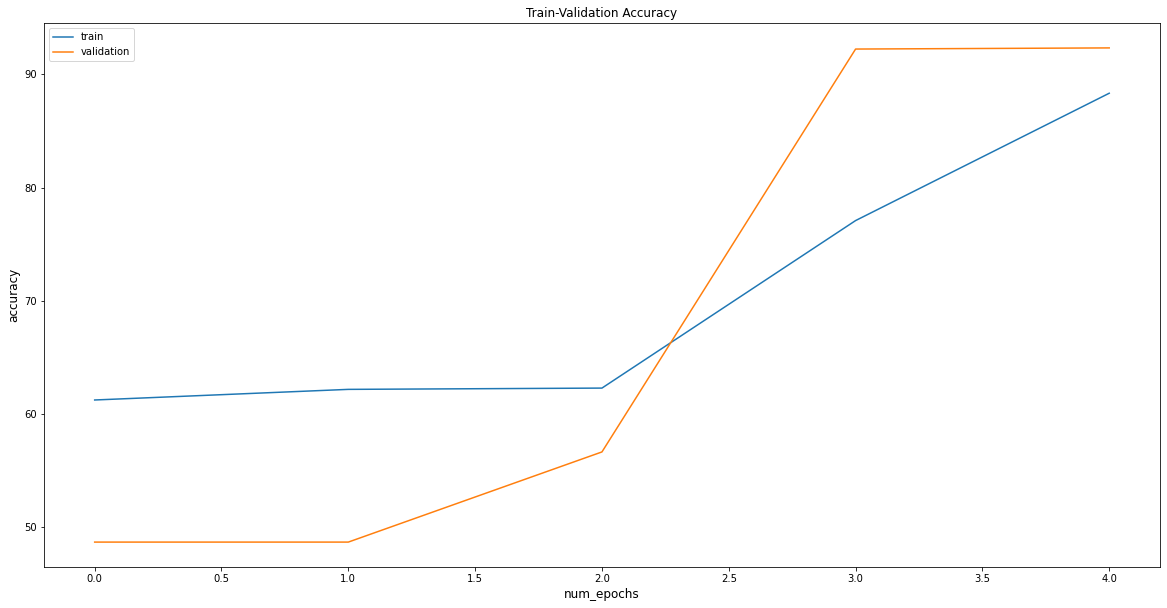

In [61]:
ig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [62]:
from matplotlib.pyplot import * 
from PIL import Image

In [63]:
from torch.utils.data import Dataset
use_cuda = True

trans = torchvision.transforms.Compose(
[
    torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [64]:
net.load_state_dict(torch.load('shufflenet.pt'))
test_dataset = torchvision.datasets.ImageFolder(root='./New Masks Dataset/Face Mask Dataset/Validation', transform=trans)
net.cuda()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [65]:
data_dir_valid = './New Masks Dataset/Face Mask Dataset/Validation'
MODEL_STORE_PATH = './'
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(64, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ]),
}

train_dataloader1, test_dataloader1 , classes1, dataset_sizes1=get_dataset(data_dir,data_transforms)
print('Classes: ',  classes1)

Classes:  ['WithMask', 'WithoutMask']


In [66]:
from torch.utils.data import Dataset

use_cuda = True
import time

TPR = []
FPR = []
dataLable = []
predict = []

inp = []
out = []


def model_metric(net):
    alls = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    j = 0
    time1 = 0
    batch = 4
    loss = 0
    for i, data in enumerate(train_dataloader1):
        j += batch
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
            if inputs.shape[0] != batch:
                continue
        start_time = time.time()
        outputs = net(inputs)
        time1 += (time.time() - start_time)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()

        for j in range(0, batch - 1):
            inp.append(labels[j])
            out.append(preds[j])
            if ((labels[j] == preds[j]) and (preds[j] == 1)): tp += 1
            if ((labels[j] != preds[j]) and (preds[j] == 1)): fp += 1
            if ((labels[j] != preds[j]) and (preds[j] == 0)): fn += 1
            if ((labels[j] == preds[j]) and (preds[j] == 0)): tn += 1
            dataLable.append(labels[j])
            predict.append(preds[j])

    recall = (tp) / (tp + fn)
    precision = (tp) / (tp + fp)
    f1 = 2 * ((precision * recall) / (precision + recall))
    print("False Negative = ", fn)
    print("Recall =", recall)
    print("Precision =", precision)
    print("f1 =", f1)
    print("Time predict =", time1 / j)

    print("all param = ", sum(p.numel() for p in net.parameters()))
    print("learn param = ", sum(p.numel() for p in net.parameters() if p.requires_grad))


model_metric(net)

loss = F.binary_cross_entropy(F.sigmoid(torch.Tensor(inp)), torch.Tensor(out))
print("LogLoss = ", loss)

False Negative =  595
Recall = 0.8404825737265416
Precision = 0.8903720533939222
f1 = 0.8647083160943317
Time predict = 21.72704768180847
all param =  1255654
learn param =  1255654
LogLoss =  tensor(0.6102)


In [67]:


data_transforms =  transforms.Compose([
            transforms.Resize(64, interpolation=2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])
    


frame =Image.open("C:/University/Магистратура 4 семестр/CraftDS/NM/10.jpg")  
img = data_transforms(frame)
torch.Tensor(img).unsqueeze(3).shape

start_time = time.time()
output = net(torch.Tensor(img).unsqueeze(0).cuda())
time1 = (time.time() - start_time)
time1


0.015957117080688477